# Kernel Density Estimation


This is just a collection of example gists, working towards a re-usable function.

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html  
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/  
https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28  

https://github.com/tommyod/KDEpy  
https://kdepy.readthedocs.io/en/latest/examples.html   

https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0  
https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab  
https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb  

https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python  
https://www.homeworkhelponline.net/blog/math/tutorial-kde  

https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html  
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation  
https://scikit-learn.org/stable/modules/density.html  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html  
  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html  
https://glowingpython.blogspot.co.za/2012/08/kernel-density-estimation-with-scipy.html  
https://pythonhosted.org/PyQt-Fit/KDE_tut.html  

Violin Plots  
https://www.mathsisfun.com/data/quartiles.html  
https://mode.com/blog/violin-plot-examples  
https://python-graph-gallery.com/violin-plot/  


Jake vdPlas makes a good point why and how histograms are not really good probability density estimators [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html#Motivating-KDE:-Histograms).  Depending on how the data points fall into the bins strange effects may arise.  He writes 'The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points. This mis-alignment between points and their blocks is a potential cause of the poor histogram results.

The histogram approach is to have (normally same-size) fixed bin edges, in to which the data points are falling and being counted. The Kernel Density method works the other way around make fixed-width block around each data point and add up the blocks' heights.  This way the weights add up around the data points' locations.  This is somewhat making a bin centred around each data point and then adding up the bin counts at a fine resolution.

Working with rectangular blocks the new density function has rough edges at the blocks' corners. The next logical step is to use smooth functions (called kernels) instead of rectangular blocks. This yields smooth functions with more appropriate density distributions than does the traditional histogram.  In this approach you must define/select the kernel shape and width. If the kernel is too wide a kernel's influence can be too wide, masking the data points. If the kernel is too narrow it will leave 'holes' between the data points. Just image a dirac delta kernel function which simply repeats the data set.

scikit-learn provides an efficient library for kernel density estimation. The library provides six different kernel shapes and a method whereby an appropriate  kernel width can be found.

This notebook investigates KDE as explained by JvdP and then develops a packaged function that can be readily used elsewhere.

This code requires a scikit learn version higher than 0.19. This work was done with version 0.20.1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N) #mean-0 var=1
    # create bimodal data by adding const to  entries with index > f*N
    # this means that some of the date keep old values and some shift 
    x[int(f * N):] += 5
    return x

## Kernel concept

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

The following code places a gaussian/normal distribution around each data point and adds them all up.

The principle here is that the gaussian placed at each data sample is a small kernel, the values of which are all added up.



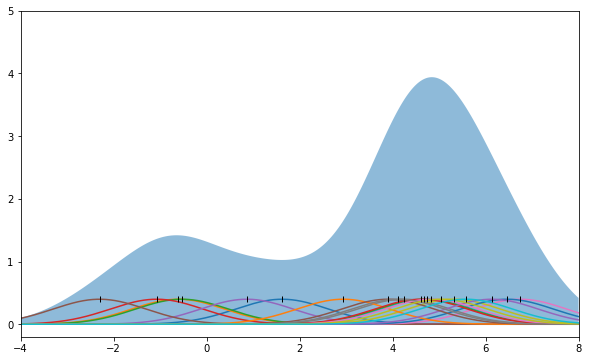

In [3]:

from scipy.stats import norm

plt.figure(figsize=(10,6))

x = make_data(20)
x_d = np.linspace(-4, 8, 1000)
for xi in x:
    plt.plot(x_d,norm(xi).pdf(x_d))
    
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, .4), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Now use the scikit learn  functions to do the same

(-0.02, 0.22)

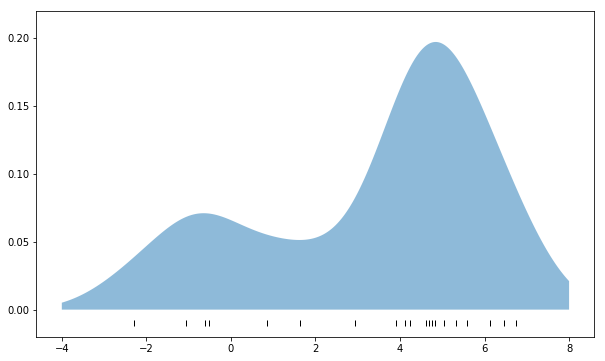

In [4]:
from sklearn.neighbors import KernelDensity

plt.figure(figsize=(10,6))

x = make_data(20)
x_d = np.linspace(-4, 8, 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(x[:, None]) # create additional axes of leng

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

https://kdepy.readthedocs.io/en/latest/examples.html#boundary-correction-using-mirroring

The gaussian kernels used above reaches to infinity and the above solution spans infinity in x.

Suppose the data is known to be bounded by zero, non-zero values are not possible.
Make the data strictly positive, and observe that the PDF has nonzero density for x<0.
this is incorrect.


(-0.02, 0.22)

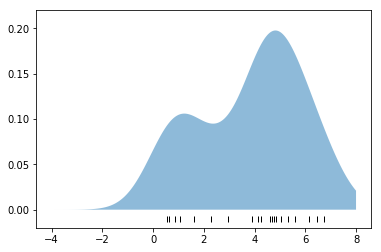

In [5]:
x = np.abs(make_data(20))
x_d = np.linspace(-4, 8, 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(x[:, None]) # create additional axes of length one

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None]) # create additional axes of length one

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

https://kdepy.readthedocs.io/en/latest/examples.html#boundary-correction-using-mirroring

To correct this 

- make a second dataset mirrored around the boundary (0 in this case)
- calculated the KDE of each set separately
- add the result of the two sets together
- select from the boundary upwards (x>=0) and reject the lower portion (x<0).

The procedure ensures that the PDF derivative at the boundary is zero.


(-0.02, 0.22)

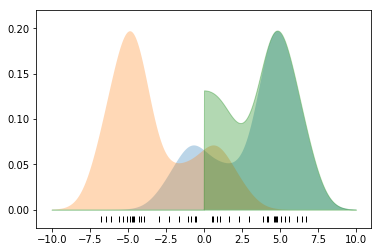

In [6]:
# single bound at 0

x = make_data(20)
x_d = np.linspace(-10, 10, 1000)

X = [x,-x]
Xo = []
for i,x in enumerate(X):
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=1, kernel='gaussian')
    kde.fit(x[:, None]) # create additional axes of length one

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None]) # create additional axes of length one
    Xo.append(np.exp(logprob))
    plt.fill_between(x_d, np.exp(logprob), alpha=0.3)
    plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    plt.ylim(-0.02, 0.22)
    
x = Xo[0] + Xo[1]
x = np.where(x_d<0,0,x)
plt.fill_between(x_d, x, alpha=0.3,color='g')
plt.ylim(-0.02, 0.22)


To extend to an upper and lower boundary, just repeat the process on both sides.

(-0.02, 0.22)

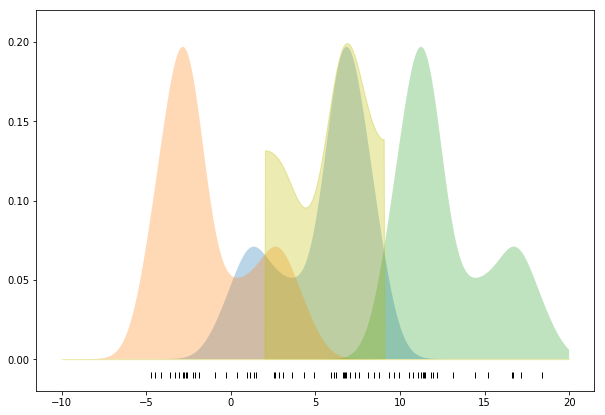

In [7]:
# two boundsL lower at fixed and upper at max of values + .3
lowbnd = 2
uppdelta = .3

# limit at lower bound
x = make_data(20) + lowbnd
uppbnd = np.max(x) + uppdelta

x_d = np.linspace(-10, 20, 1000)

X = []
Xo = []

# base data
X.append(x)
#flip lower bound  
y = -x + 2 * lowbnd
X.append(y)
# flip upper bound
y = -x + 2 * uppbnd
X.append(y)

plt.figure(figsize=(10,7))
for i,x in enumerate(X):
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=1, kernel='gaussian')
    kde.fit(x[:, None]) # create additional axes of length one

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None]) # create additional axes of length one
    Xo.append(np.exp(logprob))
    plt.fill_between(x_d, np.exp(logprob), alpha=0.3)
    plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    plt.ylim(-0.02, 0.22)

x = np.zeros_like(x_d)
for xi in Xo:
    x += xi

x = np.where(x_d<=lowbnd,0,x)
x = np.where(x_d>=uppbnd,0,x)

plt.fill_between(x_d, x, alpha=0.3,color='y')
plt.ylim(-0.02, 0.22)


The following function encapsulates and generalises all of the preceeding discussion.  This function can be conveniently used elsewhere in your code.

In [8]:
def KDEbounded(x_d,x,bandwidth=np.nan,lowbnd=np.nan,uppbnd=np.nan,kernel = 'gaussian'):
    """Estimate the probability by Kernel Density Estimation

    If bandwidth is np.nan, calculate the optimal kernel width, aka bandwidth.  
    Be careful, this can take a while.

    Mirrors the data at either or both of the edges if the domain is bounded.

    Args:
        | x_d (np.array[N,]): domain over which values must be returned
        | x (np.array[N,]): sample data set
        | bandwidth (float): the kernel width to be used, np.nan if to be calculated
        | lowbnd (float): lower mirror fold boundary, np.nan means no lower bound and mirror
        | uppbnd (float): upper mirror fold boundary, np.nan means no upper bound and mirror
        | kernel (str): kernel to be used [‘gaussian’|’tophat’|’epanechnikov’|’exponential’|’linear’|’cosine’]


    Returns:
        | x_d (np.array[N,]): input vector used as domain for the calculations
        | x (np.array[N,]): probability density over x_d, the range of the PDF
        | bandwidth (float): bandwidth used in the KDE
        | kernel (str): kernel used 

    Raises:
        | No exception is raised.

    https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html#Motivating-KDE:-Histograms
    https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python
    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python
    https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
    https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab
    https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb
   
    """

    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import LeaveOneOut
   
    
    # find optimal bandwidth if not supplied
    if np.isnan(bandwidth):
        bandwidths = 10 ** np.linspace(-1, 1, 100)
        kd = KernelDensity(kernel=kernel)
        grid = GridSearchCV(kd,param_grid={'bandwidth': bandwidths},
                            cv=LeaveOneOut())
        grid.fit(x[:, None]); # create additional axes of length one
        bandwidth = grid.best_params_['bandwidth']
 
    X = []
    Xo = []
    
    # base data, and if required lower flipped, upper flipped
    X.append(x)
    if not np.isnan(lowbnd):
        X.append(-x + 2 * lowbnd)
    if not np.isnan(uppbnd):
        X.append(-x + 2 * uppbnd)

    # do for base, and if present lower and upper flipped
    for i,x in enumerate(X):
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
        kde.fit(x[:, None]) # create additional axes of length one
        # score_samples returns the log of the probability density
        prob = np.exp(kde.score_samples(x_d[:, None])) # create additional axes of length one
        Xo.append(prob)

    # add base and flipped together
    x = np.zeros_like(x_d)
    for xi in Xo:
        x += xi

    # only cut out the base domain
    if not np.isnan(lowbnd):
        x = np.where(x_d<=lowbnd,0,x)
    if not np.isnan(uppbnd):
        x = np.where(x_d>=uppbnd,0,x)
    
    return x_d,x,bandwidth, kernel


In [9]:
# helper function to set up experiments
def showexperiment(bounds=(np.nan,np.nan),bandwidth=np.nan,scale=1,offset=0,kernel='gaussian'):
    
    x = scale * make_data(20) + offset
    
    if not np.isnan(bounds[0]) and not np.isnan(bounds[1]):
        lowbnd = bounds[0]
        uppbnd = bounds[1]
        x_d = np.linspace(lowbnd,uppbnd, 1000)
    else:
        lowbnd = np.nan
        uppbnd = np.nan
        tenp = (np.max(x) - np.min(x)) / 10
        x_d = np.linspace(np.min(x)-tenp,np.max(x)+tenp, 1000)

    x_d,kde,bandwidth,kernel = KDEbounded(x_d,x,bandwidth=bandwidth,lowbnd=lowbnd,uppbnd=uppbnd, kernel=kernel)

    print(f'x.min={np.min(x):.4e}  x.max={np.max(x):.4e} x.shape={x.shape}')
    print(f'x.min={np.min(x_d):.4e}  x.max={np.max(x_d):.4e} x.shape={x_d.shape}')
    print(f'Bandwidth={bandwidth}')
    print(f'kernel={kernel}')
    print(f'Integral of PDF={np.trapz(kde,x_d)}')

    plt.figure(figsize=(10,7))
    plt.fill_between(x_d, kde, alpha=0.3,color='y')
    plt.plot(x, np.full_like(x, -0.011*np.max(kde)), 'ok', markeredgewidth=1)
    plt.xlim(np.min(x_d),np.max(x_d))
    plt.xlabel('$x_d$')
    plt.ylabel(f'Probability density')

The first example has is unbounded, i.e., the PDF can extend to any value on $x\in {\rm I\!R}$. The plots only show 10% wider than the input data on either side.

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.2062e+00  x.max=7.6494e+00 x.shape=(1000,)
Bandwidth=1.1233240329780276
kernel=gaussian
Integral of PDF=0.9607252940685365


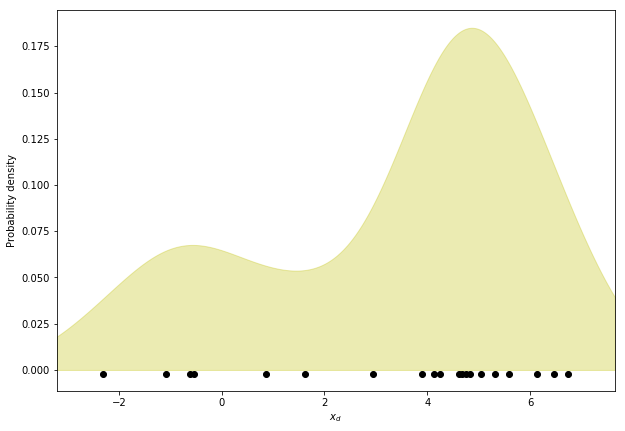

In [10]:
showexperiment()    

Now limit the domain for the PDF, in this case corresponding to the minimum and maximum input values.

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-2.3010e+00  x.max=6.7448e+00 x.shape=(1000,)
Bandwidth=1.1233240329780276
kernel=gaussian
Integral of PDF=0.9988190205097955


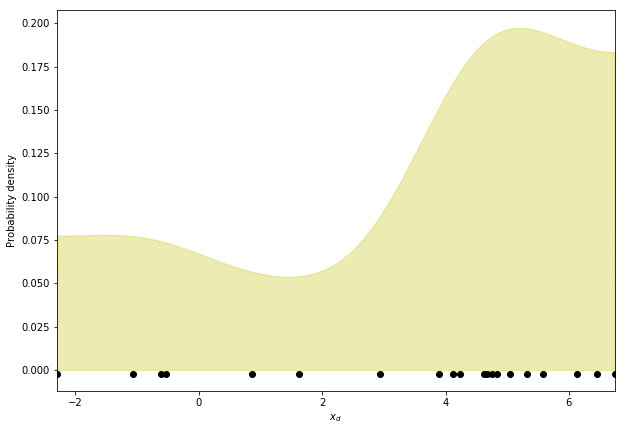

In [11]:
showexperiment(bounds=[-2.301,6.74481], bandwidth=np.nan, scale=1,offset=0)    

Limit the domain for the PDF, somewhat wider than the  minimum and maximum input values.

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.3010e+00  x.max=7.7448e+00 x.shape=(1000,)
Bandwidth=1.1233240329780276
kernel=gaussian
Integral of PDF=0.9994299785818043


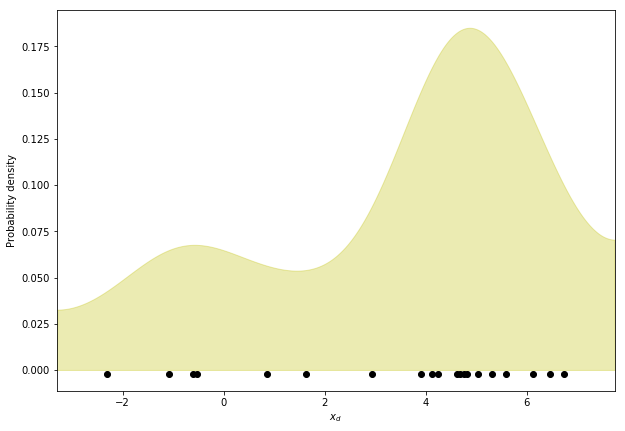

In [12]:
showexperiment(bounds=[-3.301,7.74481], bandwidth=np.nan, scale=1,offset=0)    

Repeat the previous but use the top hat kernel

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.3010e+00  x.max=7.7448e+00 x.shape=(1000,)
Bandwidth=1.7886495290574351
kernel=tophat
Integral of PDF=0.9995783653125939


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


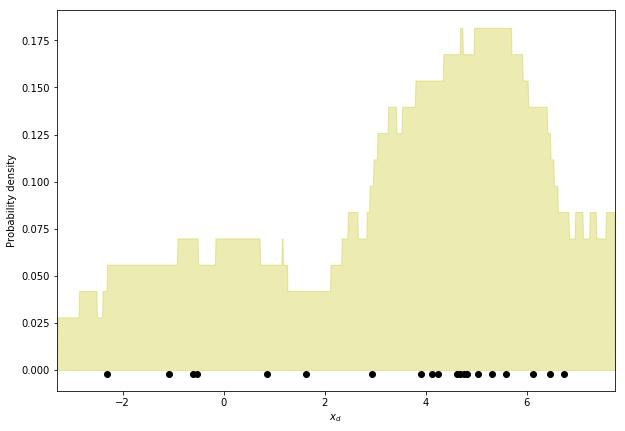

In [13]:
showexperiment(bounds=[-3.301,7.74481], bandwidth=np.nan, scale=1,offset=0,kernel = 'tophat')    

Repeat the previous but use a narrower top hat kernel

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.3010e+00  x.max=7.7448e+00 x.shape=(1000,)
Bandwidth=0.1
kernel=tophat
Integral of PDF=1.0006464514514513


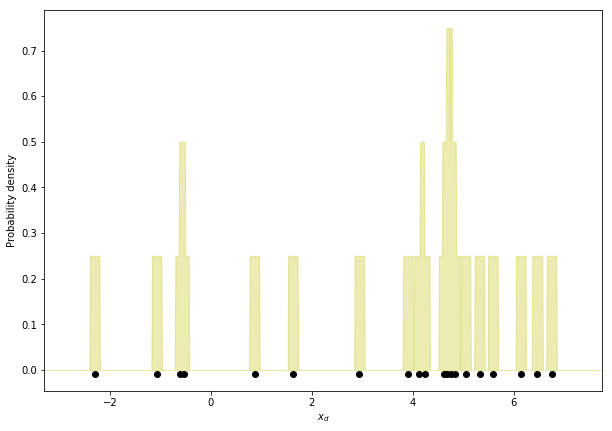

In [14]:
showexperiment(bounds=[-3.301,7.74481], bandwidth=.1, scale=1,offset=0,kernel = 'tophat')    

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [15]:
## to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark

%load_ext watermark
# %watermark -v -m -p numpy,scipy,pyradi -g -d
%watermark -v -m -p numpy,scipy,pyradi,pandas,sklearn -g -r -u -d -b -i

last updated: 2019-05-23 2019-05-23T14:47:51+02:00

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
pyradi 1.1.4
pandas 0.23.4
sklearn 0.20.1

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : b24e5d582877cfef3683ce2916c09418e0f6a88a
Git repo   : https://github.com/NelisW/PythonNotesToSelf.git
Git branch : master
